c班に向けて。
分類のサイズを変えなさい
損失関数変更に対応しなさい
最適化手法変更に対応しなさい

In [1]:
import tqdm
import pandas as pd
import torch
import seaborn as sns
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


条件記録変数の初期化

In [2]:
parameters = {}

### データの読み込み
表形式のデータを扱うのに長けた，pandasでデータを読み込む。
pandasにはread_csv()やread_excel()関数があり，一般的な表形式データをそのまま読み込むことができる。

In [3]:
df = pd.read_csv("./data/07C_regression_Material_Propaties.csv")

Jupyter Notebook形式でスクリプトを書いている場合，セルの最終行に変数名だけを記載した場合，その内容が表示される。
その他の場所で表示がしたい場合はprint()関数の使用が必要

In [4]:
df

,Standard (Std),Unique Identification code for the Material (ID),Material Name,Heat Treatment Method,Ultimate Tensile Strength (Su) in Mpa,Yield Strength (Sy) in Mpa,Elongation at Break or Strain (A5) as a Percentage,Brinell Hardness Number (BHN) in Microhardness Units,Elastic Modulus (E) in Mpa,Shear Modulus (G) in Mpa,Poisson's Ratio (mu) in Units of Length,Density (Ro) in Kg/m3,Pressure at Yield (pH) in Mpa,Description of the Material (Desc),Vickers Hardness Number (HV)
0,ANSI,D8894772B88F495093C43AF905AB6373,Steel SAE 1015,as-rolled,421.0,314.0,39.0,126.0,207000.0,79000.0,0.30,7860.0,NaN,NaN,NaN
1,ANSI,05982AC66F064F9EBC709E7A4164613A,Steel SAE 1015,normalized,424.0,324.0,37.0,121.0,207000.0,79000.0,0.30,7860.0,NaN,NaN,NaN
2,ANSI,356D6E63FF9A49A3AB23BF66BAC85DC3,Steel SAE 1015,annealed,386.0,284.0,37.0,111.0,207000.0,79000.0,0.30,7860.0,NaN,NaN,NaN
3,ANSI,1C758F8714AC4E0D9BD8D8AE1625AECD,Steel SAE 1020,as-rolled,448.0,331.0,36.0,143.0,207000.0,79000.0,0.30,7860.0,NaN,NaN,NaN
4,ANSI,DCE10036FC1946FC8C9108D598D116AD,Steel SAE 1020,normalized,441.0,346.0,35.8,131.0,207000.0,79000.0,0.30,7860.0,550.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548,JIS,38526441BA8741CA979DBF870D0B8A9B,Nodular cast iron,NaN,700.0,420.0,NaN,NaN,169000.0,70000.0,0.20,7160.0,560.0,Nodular cast iron,230.0
1549,JIS,CAC03D7EB1AA45E68EFF92A2EF4C3D9B,Nodular cast iron,NaN,800.0,480.0,NaN,NaN,169000.0,70000.0,0.20,7160.0,600.0,Nodular cast iron,240.0
1550,JIS,45C82A36EC644F8BB6170A99ED819B62,Malleable cast iron,NaN,400.0,180.0,4.0,NaN,160000.0,64000.0,0.27,7160.0,300.0,Malleable cast iron,220.0
1551,JIS,BC74F870412F4DDBADDEF1063C1C079F,Malleable cast iron,NaN,500.0,260.0,4.0,NaN,160000.0,64000.0,0.27,7160.0,370.0,Malleable cast iron,230.0


# データの可視化
import seaborn as sns
でインポートしたseabornモジュールを使用して，各数値間の関係を可視化する。

In [5]:
# データの可視化
#sns.pairplot(df)#, hue="age")
#plt.show()

データの加工

In [6]:
# 文字列データを数値に変換
# 列に対してループ
for column in df.columns:
    
    # 列名称とデータ型を表示
    print(f"-----------------------------------------")
    print(f"col name: {column}, dtype: {df[column].dtype}")

    # ユニークな値のリストを表示
    print(f"unique values:{df[column].unique()}")
    
    # object型の列に対しては，ユニークな値を0始まりの整数に置換
    if df[column].dtype == "object":
        df[column] = pd.Categorical(df[column])
        df[column] = df[column].cat.codes
        print(f"convert:{df[column].unique()}")

df

-----------------------------------------
col name: Standard (Std), dtype: object
unique values:['ANSI' 'ISO' 'DIN' 'BS' 'CSN' 'GOST' 'NF' 'JIS'
 'https://www.kaggle.com/datasets/purushottamnawale/materials']
convert:[0 5 3 1 2 4 7 6 8]
-----------------------------------------
col name: Unique Identification code for the Material (ID), dtype: object
unique values:['D8894772B88F495093C43AF905AB6373' '05982AC66F064F9EBC709E7A4164613A'
 '356D6E63FF9A49A3AB23BF66BAC85DC3' ... '45C82A36EC644F8BB6170A99ED819B62'
 'BC74F870412F4DDBADDEF1063C1C079F' nan]
convert:[1350   44  345 ...  449 1182   -1]
-----------------------------------------
col name: Material Name, dtype: object
unique values:['Steel SAE 1015' 'Steel SAE 1020' 'Steel SAE 1022' ... 'JIS SUH310'
 'JIS SUH35' nan]
convert:[1126 1127 1128 ...  792  794   -1]
-----------------------------------------
col name: Heat Treatment Method, dtype: object
unique values:['as-rolled' 'normalized' 'annealed' 'tempered at 400 F'
 'tempered at 60

,Standard (Std),Unique Identification code for the Material (ID),Material Name,Heat Treatment Method,Ultimate Tensile Strength (Su) in Mpa,Yield Strength (Sy) in Mpa,Elongation at Break or Strain (A5) as a Percentage,Brinell Hardness Number (BHN) in Microhardness Units,Elastic Modulus (E) in Mpa,Shear Modulus (G) in Mpa,Poisson's Ratio (mu) in Units of Length,Density (Ro) in Kg/m3,Pressure at Yield (pH) in Mpa,Description of the Material (Desc),Vickers Hardness Number (HV)
0,0,1350,1126,31,421.0,314.0,39.0,126.0,207000.0,79000.0,0.30,7860.0,NaN,-1,NaN
1,0,44,1126,38,424.0,324.0,37.0,121.0,207000.0,79000.0,0.30,7860.0,NaN,-1,NaN
2,0,345,1126,30,386.0,284.0,37.0,111.0,207000.0,79000.0,0.30,7860.0,NaN,-1,NaN
3,0,190,1127,31,448.0,331.0,36.0,143.0,207000.0,79000.0,0.30,7860.0,NaN,-1,NaN
4,0,1383,1127,38,441.0,346.0,35.8,131.0,207000.0,79000.0,0.30,7860.0,550.0,-1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548,6,364,963,-1,700.0,420.0,NaN,NaN,169000.0,70000.0,0.20,7160.0,560.0,57,230.0
1549,6,1270,963,-1,800.0,480.0,NaN,NaN,169000.0,70000.0,0.20,7160.0,600.0,57,240.0
1550,6,449,860,-1,400.0,180.0,4.0,NaN,160000.0,64000.0,0.27,7160.0,300.0,55,220.0
1551,6,1182,860,-1,500.0,260.0,4.0,NaN,160000.0,64000.0,0.27,7160.0,370.0,55,230.0


In [7]:
# 欠損値(nan)の確認
df.isnull().sum()

Standard (Std)                                             0
Unique Identification code for the Material (ID)           0
Material Name                                              0
Heat Treatment Method                                      0
Ultimate Tensile Strength (Su) in Mpa                      1
Yield Strength (Sy) in Mpa                                 1
Elongation at Break or Strain (A5) as a Percentage       207
Brinell Hardness Number (BHN) in Microhardness Units    1090
Elastic Modulus (E) in Mpa                                 1
Shear Modulus (G) in Mpa                                   1
Poisson's Ratio (mu) in Units of Length                    1
Density (Ro) in Kg/m3                                      1
Pressure at Yield (pH) in Mpa                           1360
Description of the Material (Desc)                         0
Vickers Hardness Number (HV)                            1388
dtype: int64

In [8]:
# 欠損値は各列の平均値で補完する
df = df.fillna(df.mean())
df

,Standard (Std),Unique Identification code for the Material (ID),Material Name,Heat Treatment Method,Ultimate Tensile Strength (Su) in Mpa,Yield Strength (Sy) in Mpa,Elongation at Break or Strain (A5) as a Percentage,Brinell Hardness Number (BHN) in Microhardness Units,Elastic Modulus (E) in Mpa,Shear Modulus (G) in Mpa,Poisson's Ratio (mu) in Units of Length,Density (Ro) in Kg/m3,Pressure at Yield (pH) in Mpa,Description of the Material (Desc),Vickers Hardness Number (HV)
0,0,1350,1126,31,421.000000,314.000000,39.000000,126.000000,207000.000000,79000.000000,0.300000,7860.000000,627.393782,-1,328.484848
1,0,44,1126,38,424.000000,324.000000,37.000000,121.000000,207000.000000,79000.000000,0.300000,7860.000000,627.393782,-1,328.484848
2,0,345,1126,30,386.000000,284.000000,37.000000,111.000000,207000.000000,79000.000000,0.300000,7860.000000,627.393782,-1,328.484848
3,0,190,1127,31,448.000000,331.000000,36.000000,143.000000,207000.000000,79000.000000,0.300000,7860.000000,627.393782,-1,328.484848
4,0,1383,1127,38,441.000000,346.000000,35.800000,131.000000,207000.000000,79000.000000,0.300000,7860.000000,550.000000,-1,328.484848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548,6,364,963,-1,700.000000,420.000000,19.329421,177.138229,169000.000000,70000.000000,0.200000,7160.000000,560.000000,57,230.000000
1549,6,1270,963,-1,800.000000,480.000000,19.329421,177.138229,169000.000000,70000.000000,0.200000,7160.000000,600.000000,57,240.000000
1550,6,449,860,-1,400.000000,180.000000,4.000000,177.138229,160000.000000,64000.000000,0.270000,7160.000000,300.000000,55,220.000000
1551,6,1182,860,-1,500.000000,260.000000,4.000000,177.138229,160000.000000,64000.000000,0.270000,7160.000000,370.000000,55,230.000000


In [9]:
for column in df.select_dtypes(include=['object']).columns:
    df[column] = df[column].astype('float')

## データを訓練・テストに分割
データ全てを使って訓練すると，過学習（問題集の丸暗記に近い状態）となり，初めて見るデータに対する推測性能を知ることができない。
整形したデータの２割を，テストデータ，８割を訓練データとして分割する。

In [10]:
# 回帰（推定）対象を除いたデータをX，回帰対象をyとして分ける
parameters["regression_terget"] = "Elastic Modulus (E) in Mpa"
X = df.drop(parameters.get("regression_terget"), axis=1)
y = df[parameters.get("regression_terget")]

# 分割の再現性を確保するため，シード値を指定したうえで訓練データ・テストデータに分割（ここは変えない）
parameters["test_size"] = 0.2
parameters["random_seed"] = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=parameters.get("test_size"),
                                                    random_state=parameters.get("random_seed"))


分割結果の確認

In [11]:
X_train

,Standard (Std),Unique Identification code for the Material (ID),Material Name,Heat Treatment Method,Ultimate Tensile Strength (Su) in Mpa,Yield Strength (Sy) in Mpa,Elongation at Break or Strain (A5) as a Percentage,Brinell Hardness Number (BHN) in Microhardness Units,Shear Modulus (G) in Mpa,Poisson's Ratio (mu) in Units of Length,Density (Ro) in Kg/m3,Pressure at Yield (pH) in Mpa,Description of the Material (Desc),Vickers Hardness Number (HV)
1073,4,969,1199,-1,380.0,255.0,26.000000,177.138229,78000.0,0.29,7856.0,627.393782,28,328.484848
218,0,1262,816,-1,303.0,138.0,30.000000,177.138229,45000.0,0.31,8800.0,627.393782,-1,328.484848
942,2,120,332,-1,780.0,540.0,14.000000,177.138229,80000.0,0.30,7860.0,530.000000,53,239.000000
784,3,1425,554,-1,1230.0,1030.0,9.000000,177.138229,80000.0,0.30,7860.0,627.393782,53,328.484848
1083,4,1532,1122,-1,370.0,245.0,25.000000,177.138229,80000.0,0.30,7860.0,627.393782,78,328.484848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,3,822,566,-1,880.0,670.0,12.000000,177.138229,80000.0,0.30,7860.0,627.393782,42,328.484848
835,1,1382,284,-1,450.0,360.0,6.000000,177.138229,80000.0,0.30,7860.0,627.393782,78,328.484848
1216,4,513,1055,3,600.0,360.0,19.329421,177.138229,82000.0,0.30,7850.0,627.393782,68,328.484848
559,0,1520,162,29,400.0,379.0,10.000000,120.000000,26000.0,0.33,2700.0,627.393782,-1,328.484848


In [12]:
X_test.shape

(311, 14)

In [13]:
y_train.shape

(1242,)

In [14]:
y_test.shape

(311,)

## データをpytorch用に変換
データを変換し，モデルが読み込めるようにデータローダーを定義する。

In [15]:
# torchテンソルに変換
X_train = torch.tensor(X_train.values, dtype=torch.float)
X_test = torch.tensor(X_test.values, dtype=torch.float)
y_train = torch.tensor(y_train.values, dtype=torch.float).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float).view(-1, 1)

# データローダー定義用に変換
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# データローダー定義
parameters["batch_size"] = 16
train_loader = DataLoader(train_dataset, batch_size=parameters.get('batch_size'), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


In [16]:
# テンソル形状の確認
for batch, (X, y) in enumerate(train_loader):
    pass
print(f"batch: {batch}, X: {X.shape}, y: {y.shape}")

batch: 77, X: torch.Size([10, 14]), y: torch.Size([10, 1])


## モデルの定義
モデルの定義自体は基本的に前回の分類問題と同様。
変更するのは，入出力データのサイズ。

### 前回の入出力サイズ
入力：縦横28ピクセルのモノクロ画像データのため，１ピクセル毎の輝度データが入力，つまり28×28=784個の数値を入力とした。

出力：10種類の衣類の種類それぞれの確率を数字としたため，10個の数字が出力

### 今回の入出力サイズ
入力：各列のパラメータが対応するため，数値8個を入力する。X.shape[1]は行列の幅を返す。

出力：回帰対象，つまり単一の数値が出力


In [17]:
input_size = X.shape[1]
output_size = 1

In [18]:
# 訓練に際して、可能であればGPU（cuda）を設定します。GPUが搭載されていない場合はCPUを使用します
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))


# modelを定義します
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 256),
            nn.LeakyReLU(),
            nn.Linear(256, output_size),
            nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# モデルのインスタンスを作成
train_error = []; test_error = []; total_epochs = 0
parameters['model'] = NeuralNetwork(input_size=input_size, output_size=output_size).to(device)
model = parameters.get('model')
print(parameters['model'])

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=14, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
)


## 訓練条件の指定
損失関数，最適化アルゴリズムを指定する。
前回と違うのは，損失関数が単純に数値の誤差のため，MSELoss()を使用する点


In [19]:
parameters['loss_fn'] = nn.MSELoss()
parameters['learning_rate'] = 1e-3
parameters['optimizer'] = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'])

loss_fn = parameters.get('loss_fn')
optimizer = parameters['optimizer']

#学習スケジューラーを入れる場合はここに記述
parameters['scheduler'] = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
scheduler = parameters['scheduler']

In [20]:
def train(dataloader, model, loss_fn, optimizer, scheduler = None):

    model.train()
    RMSE = 0; size = 0

    for batch, (X, y) in enumerate(dataloader):
        size += 1
        X, y = X.to(device), y.to(device)
        
        # 損失誤差を計算
        pred = model(X)
        loss = loss_fn(pred, y)
        
        buf_fn = nn.MSELoss(); RMSE += buf_fn(pred, y).item()        
        
        # バックプロパゲーション
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    RMSE /= size
    RMSE = RMSE**0.5

    if scheduler is not None:
        try:
            scheduler.step(loss)
        except:
            scheduler.step

    return RMSE


In [21]:
def test(dataloader, model, monitor = False, range = (0,1)):
    size = 0; RMSE = 0
    model.eval()

    if monitor:
        predictions = []
        truths = []

    with torch.no_grad():
        for X, y in dataloader:
            size += 1
            X, y = X.to(device), y.to(device)
            pred = model(X)

            if monitor:
                predictions.append(pred)
                truths.append(y)

            buf_fn = nn.MSELoss(); RMSE += buf_fn(pred, y).item()        
            
    RMSE /= size
    RMSE = RMSE**0.5

    if monitor:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        predictions = torch.cat(predictions).cpu().numpy()
        truths = torch.cat(truths).cpu().numpy()
        print(range)
        plt.plot([range[0],range[1]], [range[0],range[1]], color = "black")
        plt.plot(truths, predictions, "o", color = "black", alpha = 0.5)
        plt.xlabel(f"True")
        plt.ylabel(f"Predicted")
        #rmseをテキストとして枠内に表示
        plt.text(0.05, 0.95, f"RMSE: {RMSE:.2f}", transform=plt.gca().transAxes)
        plt.subplot(1, 2, 2)
        ax2 = plt.gca()
        
        # 表示するテキストを作成
        text = ""
        for key, value in parameters.items():
            if key == 'optimizer':
                value =  str(value)[:5]
            text += f"{key}: {value}\n"

        # Subplot内にテキストを追加
        plt.text(0, 1, text, transform=ax2.transAxes, fontsize=10, verticalalignment='top')

        # グラフのタイトルなどを必要に応じて設定
        plt.title("Parameters")
        plt.axis('off') # 軸を非表示にする

        plt.show()
        
    return RMSE

In [22]:
parameters['epochs'] = 1000
total_epochs += parameters['epochs']

for t in tqdm.tqdm(range(parameters['epochs'])):
    train_error.append(train(train_loader, model, loss_fn, optimizer))
    test_error.append(test(test_loader, model, False))
    
print("完了")
print(train_error)

100%|██████████| 1000/1000 [02:41<00:00,  6.19it/s]

完了
[138183.39258855258, 120015.95055700956, 61597.68420222405, 27558.72635589269, 26338.768520557052, 25394.916339642386, 24315.673417439826, 24187.370340737747, 22979.165171955225, 23355.338625412656, 20608.658200390262, 19342.082575539127, 20333.489712723585, 32640.88175892312, 22129.692125959267, 18310.944472833165, 13747.859816657337, 11817.87121270155, 37925.79941587696, 20366.672792289984, 5512.212174008005, 5611.613955529856, 5721.69485548039, 5581.792080804635, 5649.453316529045, 12740.374886304944, 27177.37897496221, 22528.328222200144, 6298.859427940008, 5347.793358132123, 6424.76716229807, 5040.541625162915, 8401.284393563788, 6565.734076120761, 5024.893274316304, 5618.381282502722, 5338.36927858004, 5641.8977501153295, 5029.691681271711, 8988.028803850495, 7980.703113203106, 5789.542893585526, 4249.505374874791, 7721.677362365092, 6635.387999495293, 7103.809328519561, 4336.488002279063, 4530.367192340583, 5227.701238324498, 4331.5160280162345, 5001.831334493192, 6368.182482

## 学習曲線の可視化

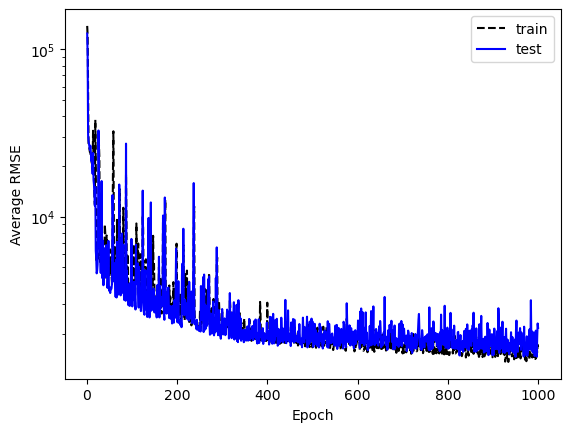

In [23]:

plt.plot(range(1,total_epochs+1), train_error, label="train", color="black", linestyle="dashed")
plt.plot(range(1,total_epochs+1), test_error, label="test", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Average RMSE")
plt.yscale('log')
plt.legend()
plt.show()


train data prediction
(np.float64(73000.0), np.float64(219000.0))


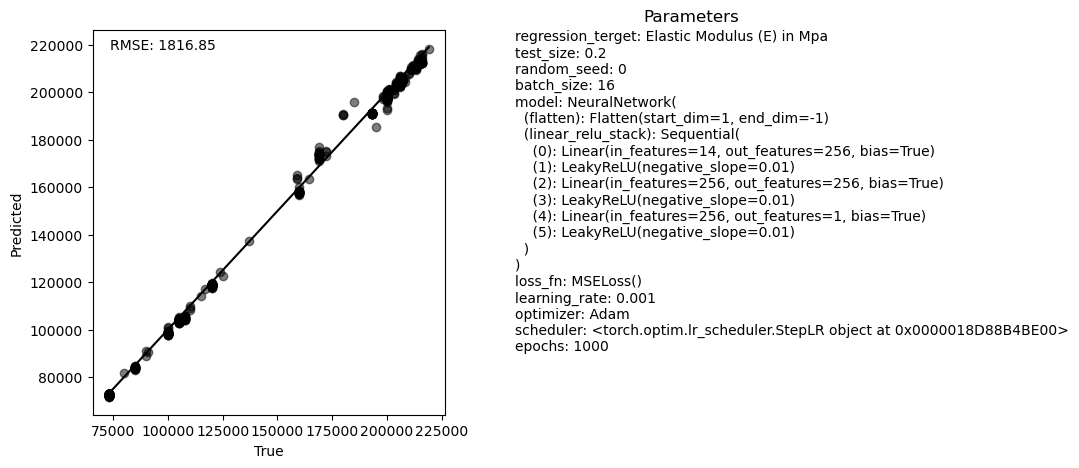

test data prediction
(np.float64(73000.0), np.float64(219000.0))


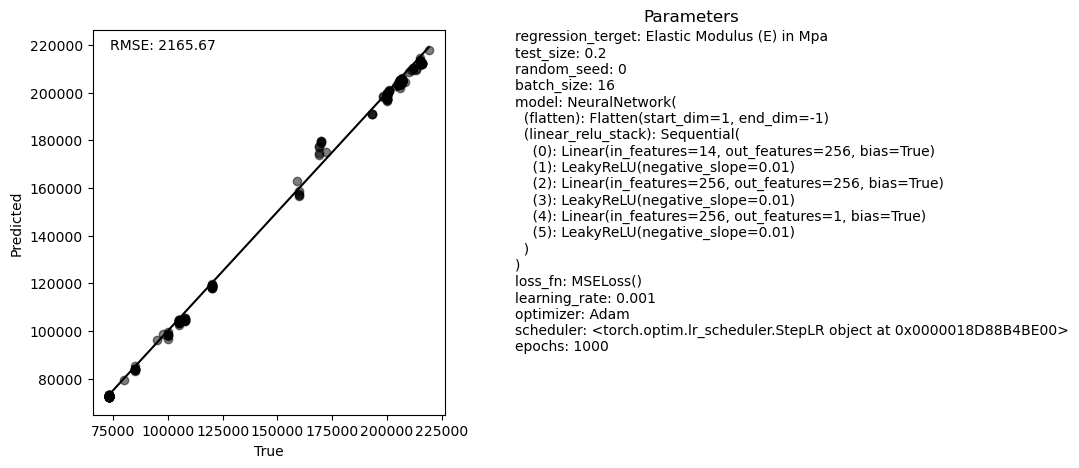

2165.666756451694

In [24]:
# 訓練データに対する予測結果を表示
print("train data prediction")
test(train_loader, model, monitor=True, range = (df[parameters['regression_terget']].min(), df[parameters['regression_terget']].max()))
# テストデータに対する予測結果を表示
print("test data prediction")
test(test_loader, model, monitor=True, range = (df[parameters['regression_terget']].min(), df[parameters['regression_terget']].max()))

## 同条件でのスコア統計取得
モデルの初期パラメータは，乱数で決定される。ので，同じ方法での訓練でも結果はばらつく。複数回の評価で，本質的に優れた方法かが評価できる。

(np.float64(73000.0), np.float64(219000.0))


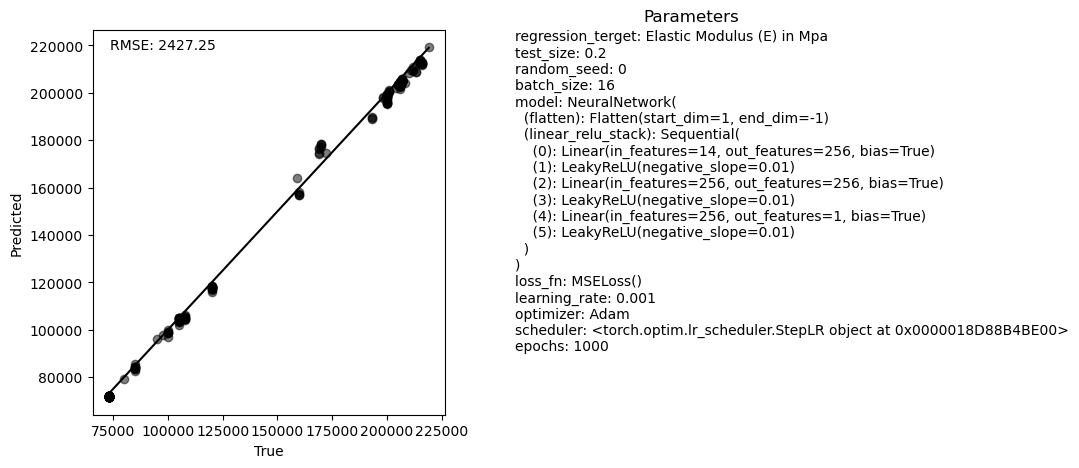

1/30: train_RMSE: 1579.92, test_RMSE: 2427.25(np.float64(73000.0), np.float64(219000.0))


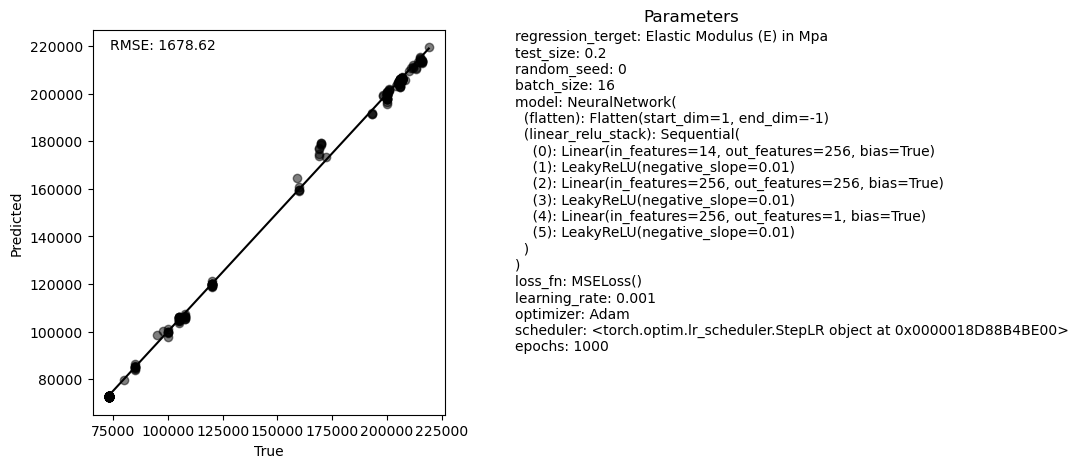

2/30: train_RMSE: 1525.23, test_RMSE: 1678.62(np.float64(73000.0), np.float64(219000.0))


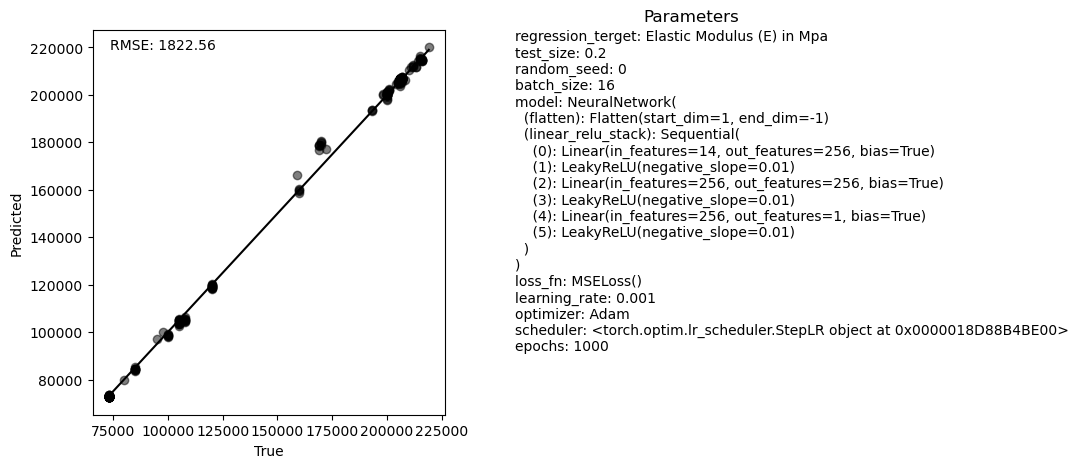

3/30: train_RMSE: 1504.26, test_RMSE: 1822.56(np.float64(73000.0), np.float64(219000.0))


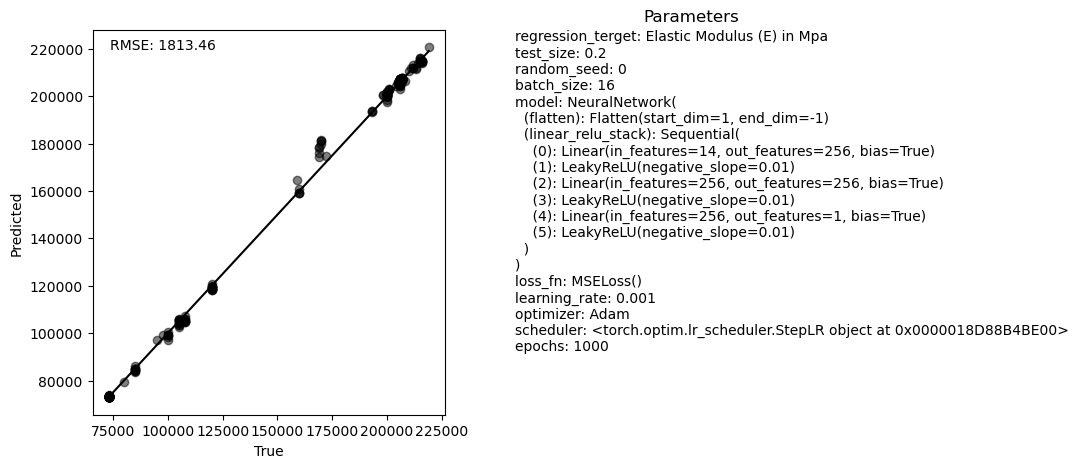

4/30: train_RMSE: 1633.16, test_RMSE: 1813.46(np.float64(73000.0), np.float64(219000.0))


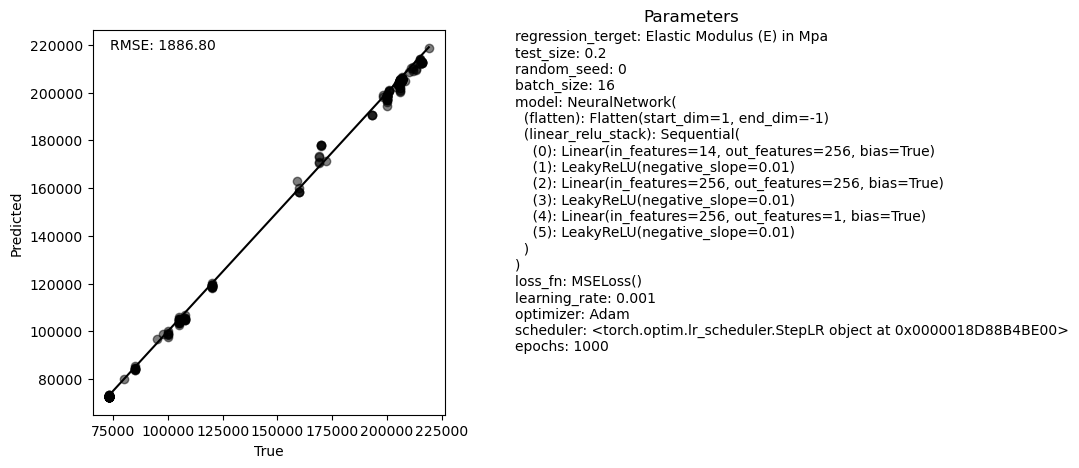

5/30: train_RMSE: 1533.65, test_RMSE: 1886.80(np.float64(73000.0), np.float64(219000.0))


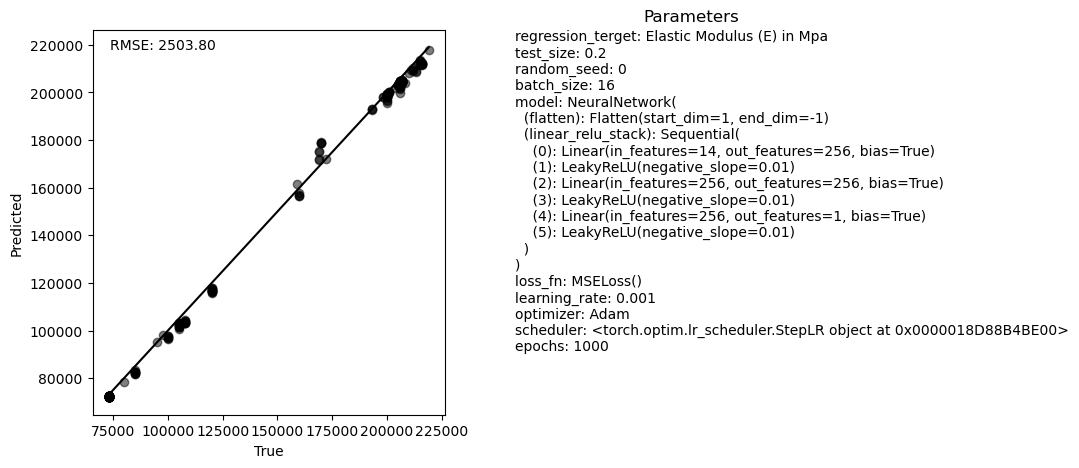

6/30: train_RMSE: 1508.05, test_RMSE: 2503.80(np.float64(73000.0), np.float64(219000.0))


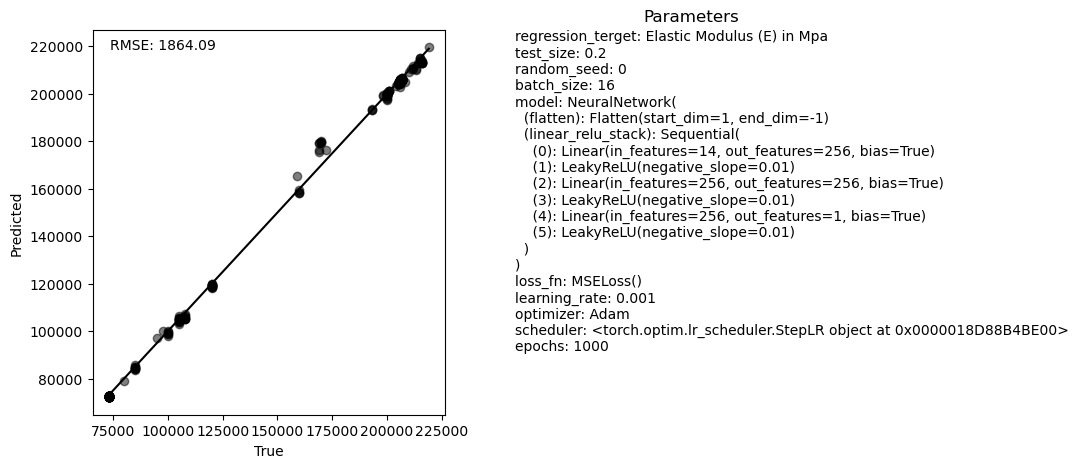

7/30: train_RMSE: 1535.11, test_RMSE: 1864.09(np.float64(73000.0), np.float64(219000.0))


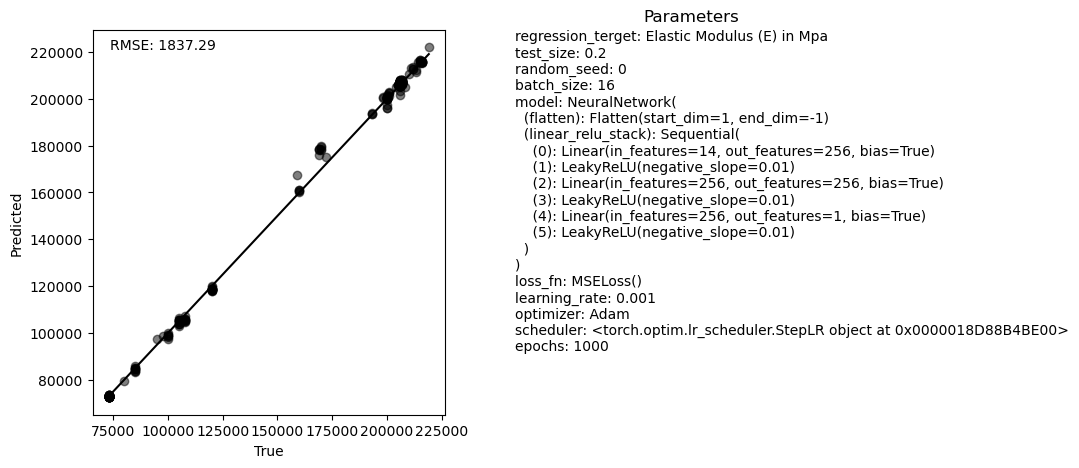

8/30: train_RMSE: 1698.65, test_RMSE: 1837.29(np.float64(73000.0), np.float64(219000.0))


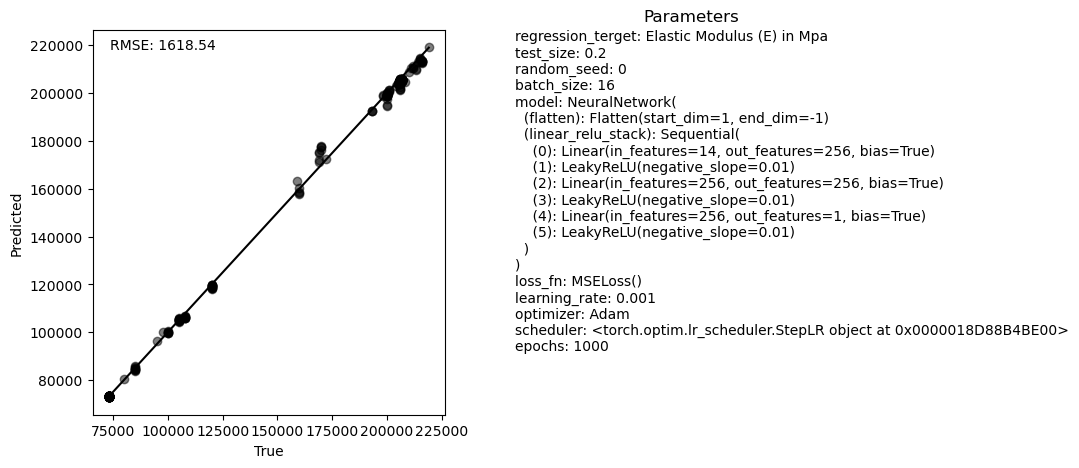

9/30: train_RMSE: 1497.16, test_RMSE: 1618.54(np.float64(73000.0), np.float64(219000.0))


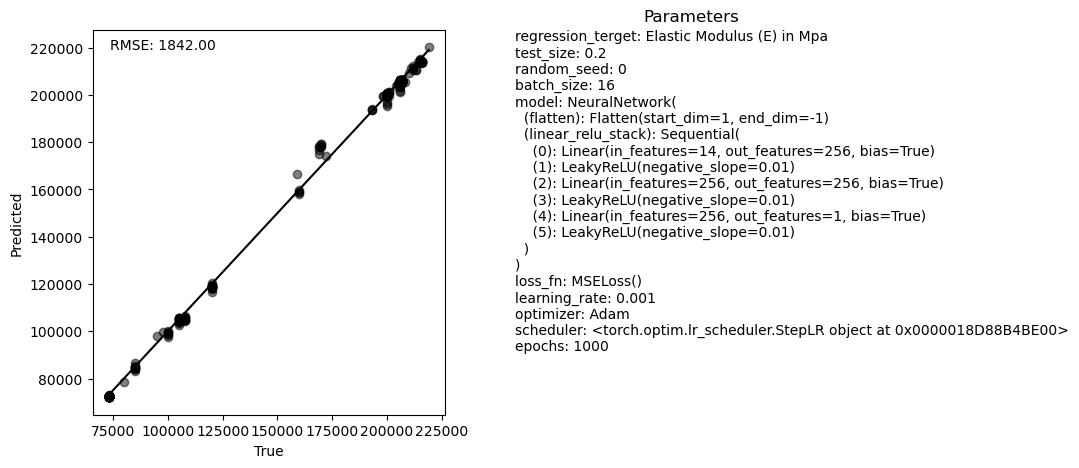

10/30: train_RMSE: 1783.30, test_RMSE: 1842.00(np.float64(73000.0), np.float64(219000.0))


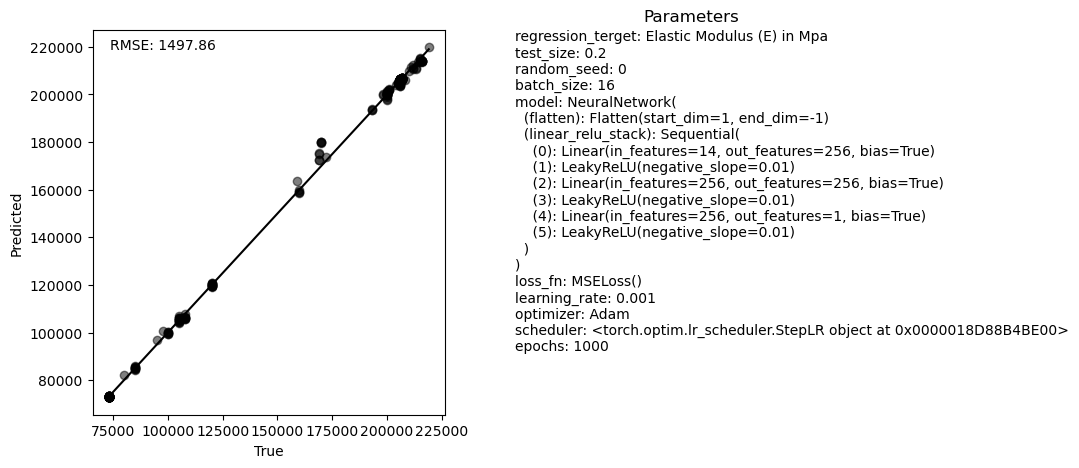

11/30: train_RMSE: 1483.32, test_RMSE: 1497.86(np.float64(73000.0), np.float64(219000.0))


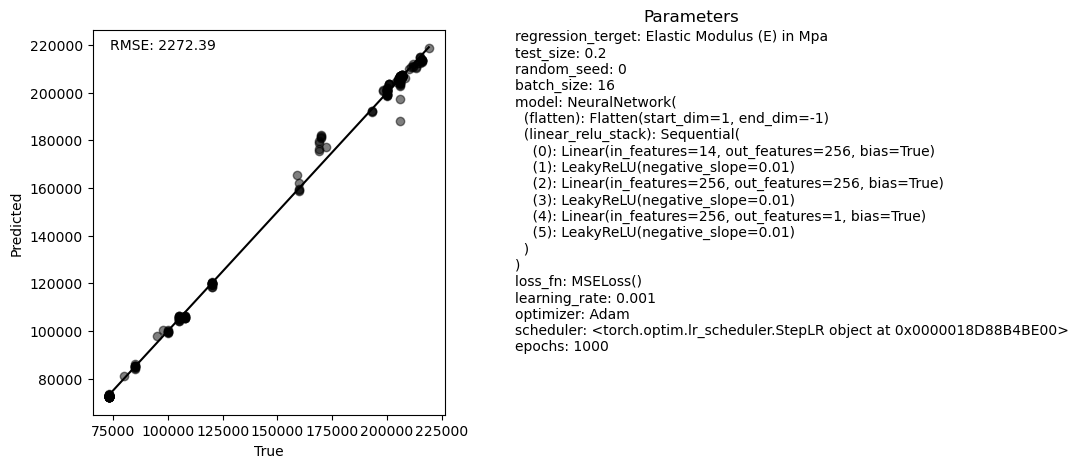

12/30: train_RMSE: 1727.38, test_RMSE: 2272.39(np.float64(73000.0), np.float64(219000.0))


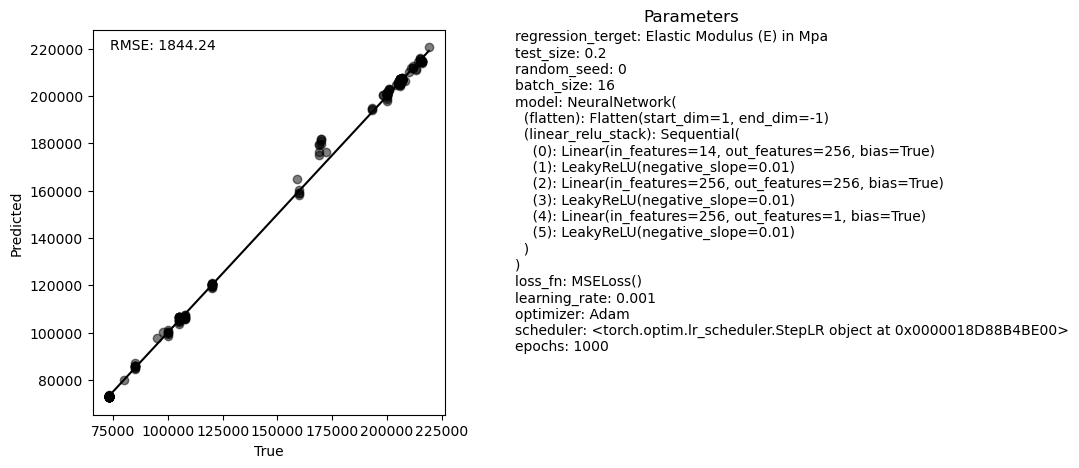

13/30: train_RMSE: 1601.05, test_RMSE: 1844.24(np.float64(73000.0), np.float64(219000.0))


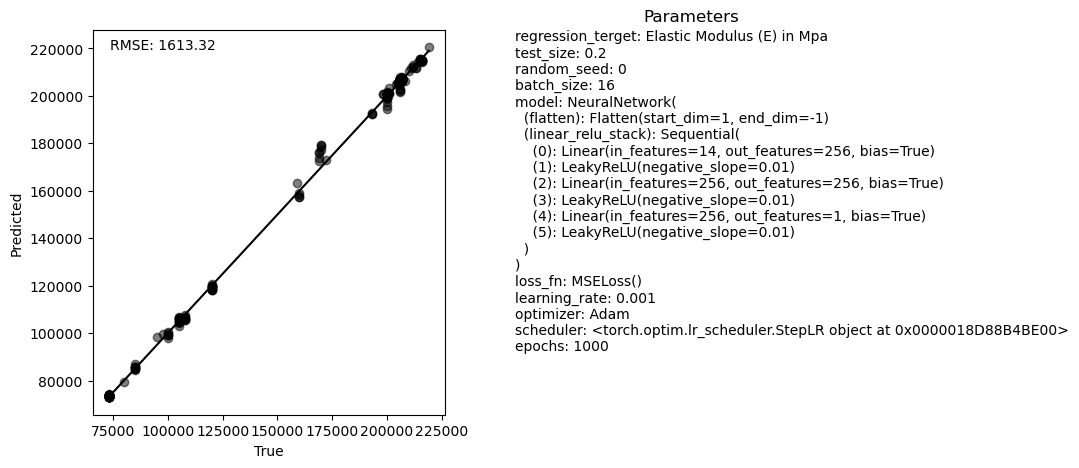

14/30: train_RMSE: 1485.48, test_RMSE: 1613.32(np.float64(73000.0), np.float64(219000.0))


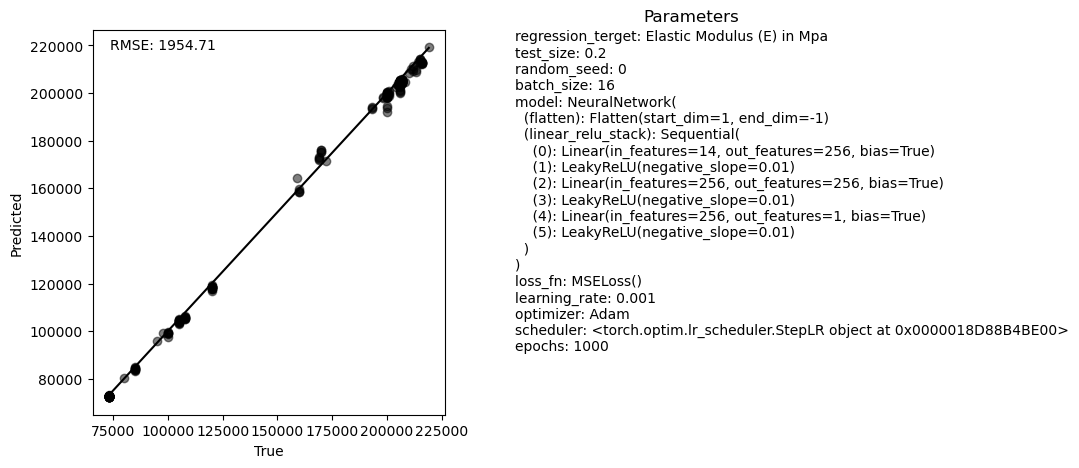

15/30: train_RMSE: 1508.62, test_RMSE: 1954.71(np.float64(73000.0), np.float64(219000.0))


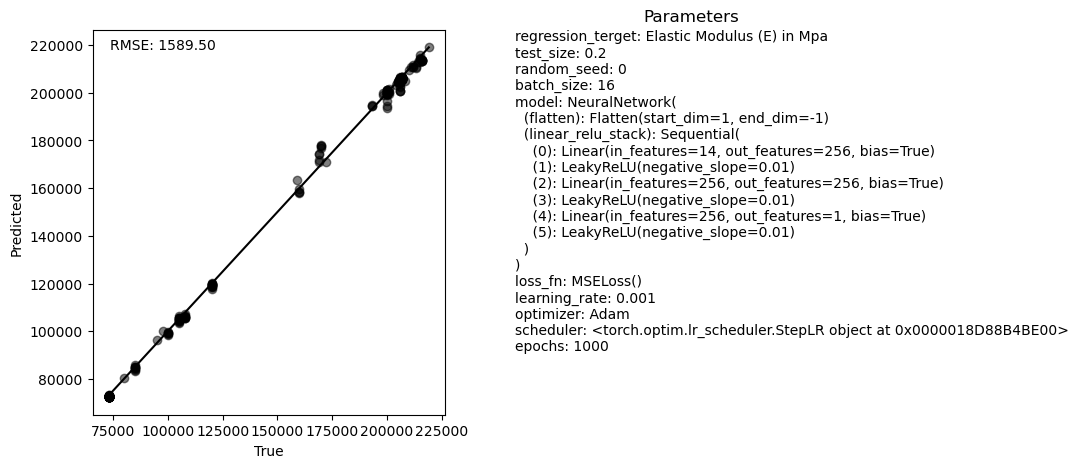

16/30: train_RMSE: 1573.03, test_RMSE: 1589.50(np.float64(73000.0), np.float64(219000.0))


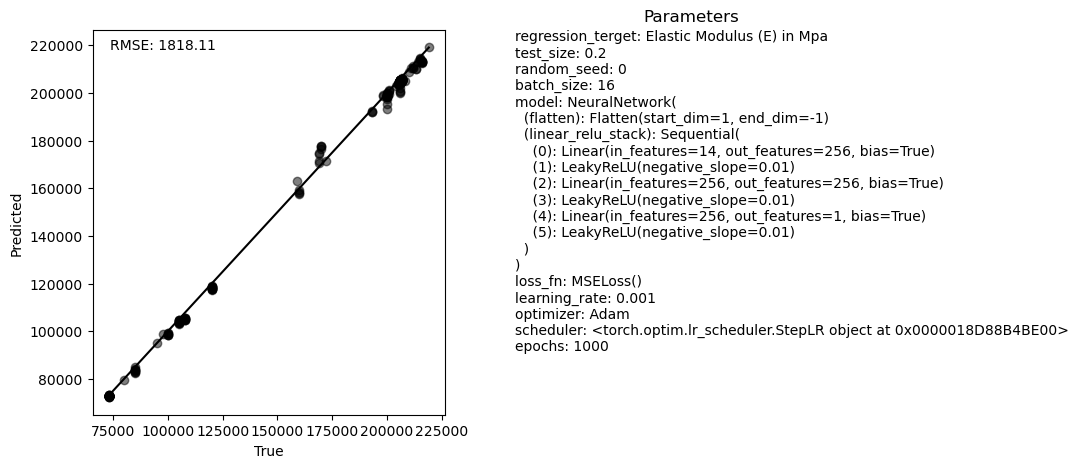

17/30: train_RMSE: 1324.06, test_RMSE: 1818.11(np.float64(73000.0), np.float64(219000.0))


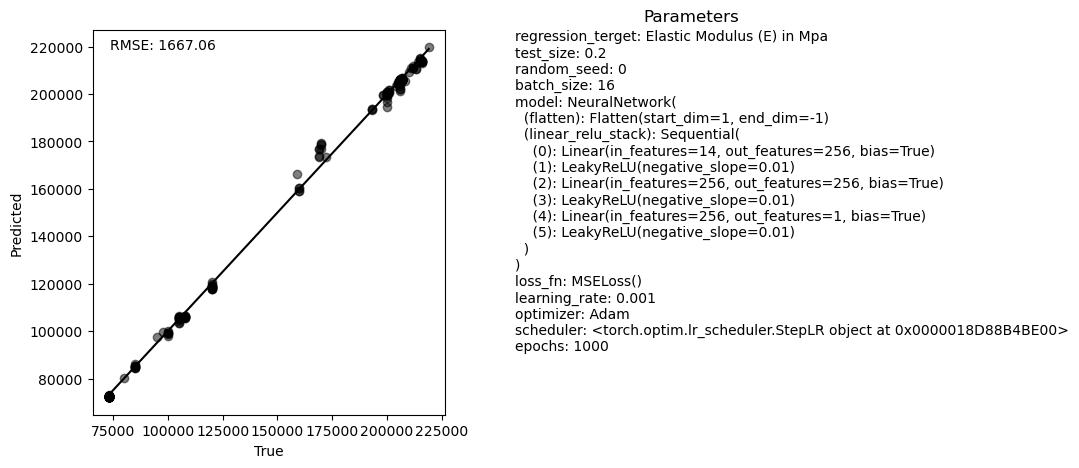

18/30: train_RMSE: 1527.50, test_RMSE: 1667.06(np.float64(73000.0), np.float64(219000.0))


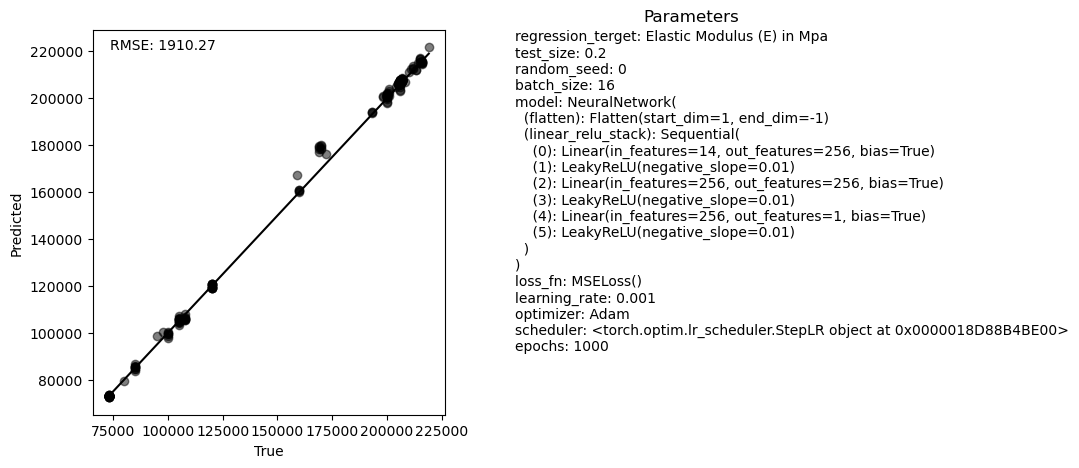

19/30: train_RMSE: 1619.75, test_RMSE: 1910.27(np.float64(73000.0), np.float64(219000.0))


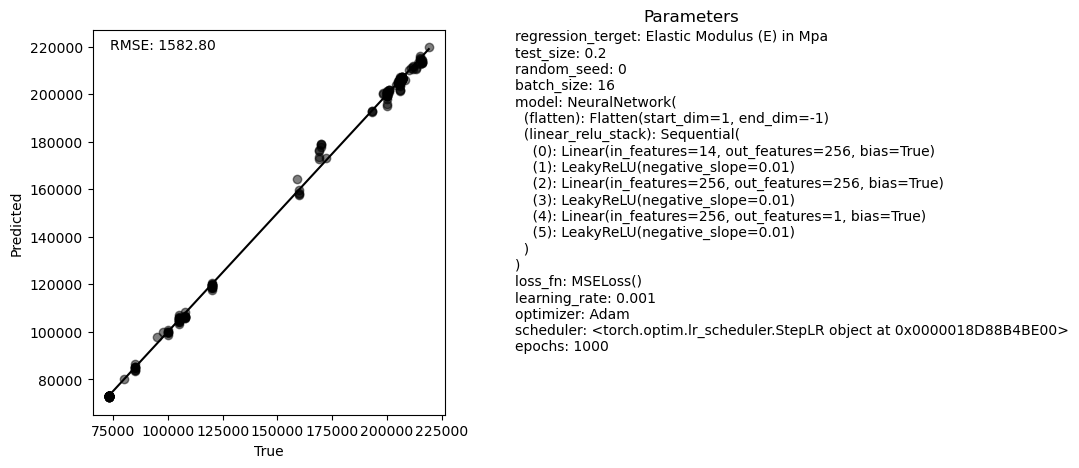

20/30: train_RMSE: 1551.95, test_RMSE: 1582.80(np.float64(73000.0), np.float64(219000.0))


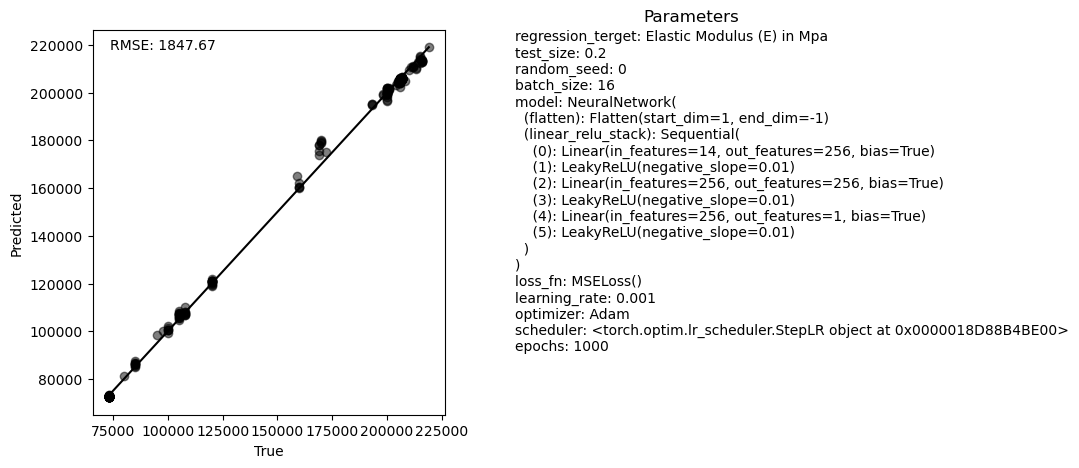

21/30: train_RMSE: 1584.84, test_RMSE: 1847.67(np.float64(73000.0), np.float64(219000.0))


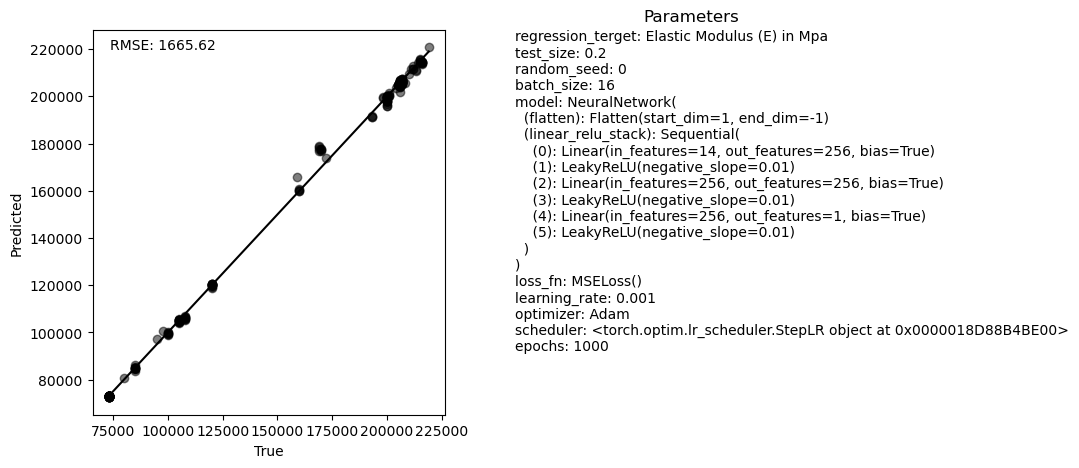

22/30: train_RMSE: 1750.14, test_RMSE: 1665.62

In [ ]:
n = 30
errors = []
for i in range(n):
    parameters['model'] = NeuralNetwork(input_size=input_size, output_size=output_size).to(device)
    model = parameters.get('model')
    parameters['optimizer'] = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'])
    optimizer = parameters['optimizer']
    #学習スケジューラーを入れる場合はここに記述

    for t in range(parameters['epochs']):
        train_RMSE = train(train_loader, model, loss_fn, optimizer)
    test_RMSE = test(test_loader, model, monitor = True, range = (df[parameters['regression_terget']].min(), df[parameters['regression_terget']].max()))
    errors.append((train_RMSE, test_RMSE))

    print(f"\r{i+1}/{n}: train_RMSE: {train_RMSE:.2f}, test_RMSE: {test_RMSE:.2f}", end='')

In [ ]:
# 繰り返した結果のバイオリンプロットを表示
error = torch.tensor(errors)
error = error.cpu().numpy()
error = error 
print(error.shape)
fig, ax = plt.subplots(figsize=(8,8))
vio = ax.violinplot(error, showmeans=False, showextrema=False, showmedians=False)
ax.set_xticks([1,2], labels=["Train", "Test"])
for body in vio['bodies']:
    body.set_color('black')
    body.set_alpha(0.6)
plt.ylabel("RMSE")
plt.ylim(0, )
plt.show()

In [ ]:
# RMSEの統計をcsvに保存
df_error = pd.DataFrame(errors, columns=["Train", "Test"])

# 日付と時刻を取得
from datetime import datetime
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")
df_error.to_csv(f"./data/RMSE_{timestamp}.csv")



ここまでを実行すると，繰り返し学習した結果における誤差（RMSE）の分布が"./data/RMSE_{timestamp}.csv"として記録される。

次に，条件を変えた際の筆画を行う。

In [ ]:
df_ref = pd.read_csv("./data/RMSE_of_Initial_Conditions.csv")

In [ ]:
#比較用に整形
df_ref = pd.read_csv("./data/RMSE_of_Initial_Conditions.csv")
df_ref_train = pd.DataFrame({'RMSE': df_ref['Train']})
df_ref_train['Data Type'] = 'Train'
df_ref_test = pd.DataFrame({'RMSE': df_ref['Test']})
df_ref_test['Data Type'] = 'Test'
df_ref_combined = pd.concat([df_ref_train, df_ref_test])
df_ref_combined['Method'] = 'Initial'

df_error_train = pd.DataFrame({'RMSE': df_error['Train']})
df_error_train['Data Type'] = 'Train'
df_error_test = pd.DataFrame({'RMSE': df_error['Test']})
df_error_test['Data Type'] = 'Test'
df_error_combined = pd.concat([df_error_train, df_error_test])
df_error_combined['Method'] = 'Your Method'

df_combined = pd.concat([df_error_combined, df_ref_combined])

#比較
f,ax=plt.subplots(figsize=(8,8))
sns.violinplot(x= "Data Type",y="RMSE",hue="Method", data=df_combined, split=True, ax=ax, inner=None, palette=["skyblue", "salmon"])
ax.set_ylabel("RMSE")
ax.set_ylim(0,)
plt.show()


In [ ]:
df_combined

### プレゼンに向けて
与えられたコードを改良し, データに対する回帰の精度を向上させ, 結果を2分のプレゼンテーションで説明せよ​。スライドには変更点と実験結果の説明を含めること​。例えば以下のような変更点が考えられる​。

1. 学習条件（エポック数, 学習係数, バッチサイズ)​

1. モデル条件（層の種別, 組み合わせ, モデルの構造)​

1. 前処理に関する変更点（正規化, 情報の種別）​

### 実験結果には以下のものを含めること​

1. テストデータに対するyyplot​

1. 改善後のRMSE値（可能であればバイオリンプロット）​

1. 結果に対する考察​


In [ ]:
from IPython.display import SVG, display
display(SVG("./figure/ルーブリック2.svg"))
